In [1]:
import pandas as pd
from enum import Enum
import os
import glob
import warnings
from utils import *
from pnc_parser import sync_pnc_data
warnings.filterwarnings('ignore')

In [2]:
filter_info = load_filter()
    
logger = Logger(log_level="INFO")

INPUT_DATA_DIR = 'data'
OUTPUT_DATA_DIR = 'output'

## TODO: Add SoFi transactions
## TODO: Add emoji after each enum text to visually identify fast
## TODO: Script to download statements
## TODO: Write a script to combine new finance data with old data
## TODO: Do -ve +ve transactions in PNC ✅
## TODO: Parse PNC from pdfs (monthly statement) and combine ✅
## TODO: Make a barchart showing start-end date of each account ✅
## TODO: instead of showing start-end date, show all transactions as points/bars

# * Don't have _notes.csv. Instead keep only one copy.
# * Keep original name of files with account number mentioned
# * For each csv, write summary of earliest & last date so as to ensure if all data loaded

class AccHolder(Enum):
    SACHIN = 'sachin'
    NOWRIN = 'nowrin'
    JOINT = 'joint'

class BankName(Enum):
    PNC = 'pnc'
    DISCOVER = 'discover'
    CHASE = 'chase'
    
class AccType(Enum):
    CHECKING = 'checking'
    CREDIT = 'credit'
    SAVINGS = 'savings'

[INFO] Logging level is: INFO


In [3]:
class Bank:
    def __init__(self, owner, acc_type, bank_name):
        self.owner = owner
        self.acc_type = acc_type
        self.bank_name = bank_name
        self.data = None

    def is_data_loaded(self):
        return not self.data is None

    def get_data(self):
        return self.data

    def load_data(self):
        pass

    def clean_data(self):
        data = self.data
        data['Date'] = pd.to_datetime(data['Date'])
        data.rename(columns={"Category": "AutoCategory"}, inplace=True)
        data['AccHolder'] = self.owner.value
        data['BankName'] = self.bank_name.value
        data['AccType'] = self.acc_type.value

        interested_columns = ['Date', 'Description', 'Amount', 'AutoCategory', 'AccHolder',
                            'BankName', 'AccType']
        data = data[interested_columns]
        self.data = data

CHASE_ACC_MAP = {
    AccHolder.SACHIN: {
        AccType.CHECKING: "5231", #
        AccType.SAVINGS: "1756", #
        AccType.CREDIT: "0770" #
    },
    AccHolder.NOWRIN: {
        AccType.CHECKING: "7138", #
        # AccType.SAVINGS: "2267",
        AccType.CREDIT: ["0009", "7345", "3157"] #
    },
    AccHolder.JOINT: {
        AccType.CHECKING: "7386", #
        AccType.CREDIT: "8113"#
    }
}   # 8 accounts

class Chase(Bank):
    def __init__(self, owner, acc_type):
        super().__init__(owner, acc_type, BankName.CHASE)

    def load_data(self):
        code = None
        if self.acc_type in CHASE_ACC_MAP[self.owner]:
            code = CHASE_ACC_MAP[self.owner][self.acc_type]
        if not code: return None
        if isinstance(code, str):
            code = [code]

        dataframes = []
        for cd in code:
            filename = f'Chase{cd}_Activity*.CSV'
            matched_files = glob.glob(f'{INPUT_DATA_DIR}/chase/{filename}')
            if len(matched_files) == 0:
                logger.error(f"Error: File missing for code: {cd}")
            elif len(matched_files) > 1:
                logger.error(f"Error: Multiple files for code: {cd}")
            df = pd.read_csv(matched_files[0], index_col=False)
            logger.debug(f"Loaded Chase data: {matched_files[0]}")
            dataframes.append(df)

        self.data = pd.concat(dataframes, ignore_index=True)

    def clean_data(self):
        data = self.data
        if data is None: return
        if self.acc_type == AccType.CREDIT:
            data['Date'] = data['Transaction Date']
        else:
            data['Date'] = data['Posting Date']
            data['Category'] = ''

        super().clean_data()

class PNC(Bank):
    def __init__(self, owner, acc_type):
        super().__init__(owner, acc_type, BankName.PNC)

    def load_data(self):
        if self.owner == AccHolder.JOINT:
            return
        if not self.acc_type == AccType.CHECKING:
            return       
        self.data = pd.read_csv(f'{INPUT_DATA_DIR}/pnc/{self.owner.value}.csv', index_col=False)

    def clean_data(self):
        data = self.data
        if data is None: return
        data['Category'] = ''
        # data['Amount'] = 0.0
        # data['Amount'] -= convert_currency_to_num(data['Withdrawals'])
        # data['Amount'] += convert_currency_to_num(data['Deposits'])

        super().clean_data()

class Discover(Bank):
    def __init__(self, owner, acc_type):
        super().__init__(owner, acc_type, BankName.DISCOVER)

    def load_data(self):
        if not self.owner == AccHolder.SACHIN:
            return
        if not self.acc_type == AccType.CREDIT:
            return
        dataframes = []
        filename = f'Discover-Last12Months-*.csv'
        matched_files = glob.glob(f'{INPUT_DATA_DIR}/discover/{filename}')
        if len(matched_files) == 0:
            print(f"Error: File missing")
        elif len(matched_files) > 1:
            print(f"Error: Multiple files")
        df = pd.read_csv(matched_files[0], index_col=False)
        dataframes.append(df)

        self.data = pd.concat(dataframes, ignore_index=True)
        
    def clean_data(self):
        data = self.data
        if data is None: return
        data['Amount'] *= -1
        data['Date'] = data['Trans. Date']

        super().clean_data()

In [4]:
def get_obj(owner, bank, acc_type):
    if bank == BankName.CHASE:
        return Chase(owner=owner, acc_type=acc_type)
    elif bank == BankName.PNC:
        return PNC(owner=owner, acc_type=acc_type)
    elif bank == BankName.DISCOVER:
        return Discover(owner=owner, acc_type=acc_type)

def merge_all_data():
    data_list = []
    for owner in AccHolder:
        for bank in BankName:
            for acc_type in AccType:
                obj = get_obj(owner, bank, acc_type)
                if not obj: continue
                obj.load_data()
                if not obj.is_data_loaded(): continue
                obj.clean_data()
                data_list.append(obj.get_data())

    full_data = pd.concat(data_list)
    full_data = full_data.sort_values(by=['Date', 'Amount'])
    full_data['AutoCategory'].fillna('', inplace=True)
    return full_data

# sync_pnc_data(INPUT_DATA_DIR)

data = merge_all_data()
write_to_excel(data, f"{OUTPUT_DATA_DIR}/full_data.xlsx")

In [8]:
YEAR = filter_info['date_period']['year']
MONTH = filter_info['date_period']['month']

part_data = filter_data_by_info(data, filter_info)

part_data_path = f"{OUTPUT_DATA_DIR}/{YEAR}_{MONTH}.xlsx"
if os.path.exists(part_data_path):
    logger.warning(f"The file {part_data_path} exists already.")
else:
    write_to_excel(part_data, part_data_path)

[WARNING] The file output/2024_6.xlsx exists already.


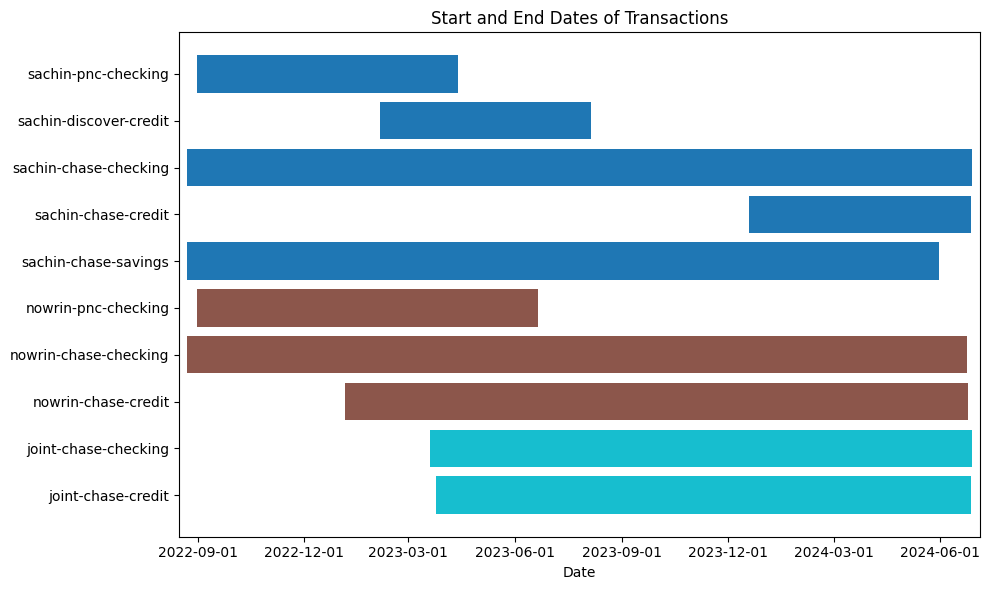

In [5]:
data = pd.read_csv(f'{OUTPUT_DATA_DIR}/full_data.csv', index_col=False)
data['Date'] = pd.to_datetime(data['Date'])
summary_df = summary_statistics(data, AccHolder, BankName, AccType)
visualize_summary(summary_df)